In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import joblib
sns.set(style='whitegrid')

print("Libraries imported.")


ModuleNotFoundError: No module named 'seaborn'

In [3]:
df = pd.read_csv("productivityPrediction.csv")
print("✅ Dataset loaded successfully.")
print("Shape:", df.shape)
df.head()


✅ Dataset loaded successfully.
Shape: (1302, 15)


,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8.0,0.80,26.16,1108.0,7080.0,98.0,0.0,NaN,0.0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1.0,0.75,3.94,NaN,960.0,0.0,0.0,0.0,0.0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11.0,0.80,11.41,968.0,3660.0,50.0,0.0,0.0,0.0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12.0,0.80,11.41,NaN,3660.0,50.0,0.0,0.0,0.0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6.0,NaN,25.90,1170.0,1920.0,50.0,0.0,0.0,0.0,56.0,0.800382


In [8]:
# — Explore data structure

print("*** Dataset Info *** :")
print(df.info())

print("\n*** Missing Values per Column ***:")
print(df.isnull().sum())

print("\n *** Summary Statistics (numeric columns) *** :")
display(df.describe())

print("\n *** Unique values in some key categorical columns ***:")
for col in ['day', 'department', 'quarter']:
    if col in df.columns:
        print(f"{col}: {df[col].unique()}")


*** Dataset Info *** :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302 entries, 0 to 1301
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1272 non-null   object 
 1   quarter                1279 non-null   object 
 2   department             1275 non-null   object 
 3   day                    1274 non-null   object 
 4   team                   1278 non-null   float64
 5   targeted_productivity  1279 non-null   float64
 6   smv                    1276 non-null   float64
 7   wip                    729 non-null    float64
 8   over_time              1276 non-null   float64
 9   incentive              1275 non-null   float64
 10  idle_time              1275 non-null   float64
 11  idle_men               1278 non-null   float64
 12  no_of_style_change     1279 non-null   float64
 13  no_of_workers          1280 non-null   float64
 14  actual_productivity    1267 non-n

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
count,1278.000000,1279.000000,1276.000000,729.000000,1276.000000,1275.000000,1275.000000,1278.000000,1279.000000,1280.000000,1267.000000
mean,6.443662,0.730274,15.061418,1148.422497,4551.332288,36.967843,0.688235,0.357590,0.146990,34.553906,0.734889
std,3.468331,0.096727,10.989957,1596.736245,3347.164546,155.419707,12.316019,3.191313,0.422717,22.256752,0.173802
min,1.000000,0.070000,2.900000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705
25%,3.000000,0.700000,3.940000,762.000000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650173
50%,7.000000,0.750000,15.260000,1040.000000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.763375
75%,9.000000,0.800000,24.260000,1255.000000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.850354
max,12.000000,0.800000,54.560000,21540.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.120437



 *** Unique values in some key categorical columns ***:
day: ['Thursday' nan 'Saturday' 'Sunday' 'Monday' 'Tuesday' 'Wednesday']
department: ['sweing' 'finishing ' 'finishing' nan]
quarter: ['Quarter1' nan 'Quarter2' 'Quarter3' 'Quarter4' 'Quarter5']


In [7]:
# — Data cleaning & preprocessing

# Strip whitespace in string columns
for col in ['department', 'quarter', 'day']:
    df[col] = df[col].astype(str).str.strip()

# Fix unexpected values in 'quarter'
df['quarter'] = df['quarter'].replace({'Quarter5': 'Quarter4'})

# Convert 'date' to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Impute missing values
# Numeric columns (except 'wip' for now)
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
numeric_cols.remove('wip')  # handle separately
for col in numeric_cols:
    df[col].fillna(df[col].mean(), inplace=True)

# Categorical columns
cat_cols = ['day', 'department', 'quarter']
for col in cat_cols:
    df[col].replace('nan', np.nan, inplace=True)
    df[col].fillna(df[col].mode()[0], inplace=True)

# Impute 'wip' with median (less sensitive to outliers)
df['wip'].fillna(df['wip'].median(), inplace=True)

# Drop rows with missing 'actual_productivity' (target)
df = df.dropna(subset=['actual_productivity'])

print("✅ Data cleaned. New shape:", df.shape)
df.head()


✅ Data cleaned. New shape: (1302, 15)


/tmp/ipython-input-1731526830.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)
/tmp/ipython-input-1731526830.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,2015-01-01,Quarter1,sweing,Thursday,8.0,0.800000,26.16,1108.0,7080.0,98.0,0.0,0.35759,0.0,59.0,0.940725
1,2015-01-01,Quarter1,finishing,Thursday,1.0,0.750000,3.94,1040.0,960.0,0.0,0.0,0.00000,0.0,8.0,0.886500
2,2015-01-01,Quarter1,sweing,Thursday,11.0,0.800000,11.41,968.0,3660.0,50.0,0.0,0.00000,0.0,30.5,0.800570
3,2015-01-01,Quarter1,sweing,Thursday,12.0,0.800000,11.41,1040.0,3660.0,50.0,0.0,0.00000,0.0,30.5,0.800570
4,2015-01-01,Quarter1,sweing,Thursday,6.0,0.730274,25.90,1170.0,1920.0,50.0,0.0,0.00000,0.0,56.0,0.800382


In [8]:
# — Feature engineering

# Per-worker features
df['wip_per_worker'] = df['wip'] / df['no_of_workers']
df['over_time_per_worker'] = df['over_time'] / df['no_of_workers']
df['idle_time_per_worker'] = df['idle_time'] / df['idle_men'].replace(0,1)  # avoid division by zero

# Target variable
target = 'actual_productivity'

# Feature columns
X_cols = df.drop(columns=[target, 'date']).columns.tolist()

print("✅ Feature engineering done. Example of new features:")
display(df[['wip_per_worker', 'over_time_per_worker', 'idle_time_per_worker']].head())


✅ Feature engineering done. Example of new features:


,wip_per_worker,over_time_per_worker,idle_time_per_worker
0,18.779661,120.000000,0.0
1,130.000000,120.000000,0.0
2,31.737705,120.000000,0.0
3,34.098361,120.000000,0.0
4,20.892857,34.285714,0.0


In [12]:
# — Preprocessing + Train/Test split


categorical_cols = ['day', 'department', 'quarter']
numeric_cols = [col for col in X_cols if col not in categorical_cols]


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ]
)


X = df[X_cols]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("✅ Preprocessing + Train/Test split done.")
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


✅ Preprocessing + Train/Test split done.
Train shape: (1041, 16) (1041,)
Test shape: (261, 16) (261,)


In [8]:
# Linear Regression pipeline
lr_pipeline = Pipeline([
    ('pre', preprocessor),
    ('model', LinearRegression())
])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

# Metrics
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression Metrics:")
print(f"RMSE: {rmse_lr:.4f}, MAE: {mae_lr:.4f}, R²: {r2_lr:.4f}\n")

# Random Forest pipeline
rf_pipeline = Pipeline([
    ('pre', preprocessor),
    ('model', RandomForestRegressor(n_estimators=200, random_state=42))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Regression Metrics:")
print(f"RMSE: {rmse_rf:.4f}, MAE: {mae_rf:.4f}, R²: {r2_rf:.4f}")


Linear Regression Metrics:
RMSE: 0.1538, MAE: 0.1089, R²: 0.1413

Random Forest Regression Metrics:
RMSE: 0.1191, MAE: 0.0716, R²: 0.4848


In [9]:
# — Hyperparameter tuning for Random Forest

from scipy.stats import randint

# Hyperparameter space
param_dist = {
    'model__n_estimators': randint(100, 500),
    'model__max_depth': randint(3, 20),
    'model__min_samples_split': randint(2, 10),
    'model__min_samples_leaf': randint(1, 5),
    'model__max_features': ['auto', 'sqrt', 'log2']
}

# Randomized search
rf_random = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

rf_random.fit(X_train, y_train)
print("✅ Best hyperparameters found:")
print(rf_random.best_params_)

# Evaluate tuned model
y_pred_rf_tuned = rf_random.predict(X_test)
rmse_rf_tuned = np.sqrt(mean_squared_error(y_test, y_pred_rf_tuned))
mae_rf_tuned = mean_absolute_error(y_test, y_pred_rf_tuned)
r2_rf_tuned = r2_score(y_test, y_pred_rf_tuned)

print("\nTuned Random Forest Metrics:")
print(f"RMSE: {rmse_rf_tuned:.4f}, MAE: {mae_rf_tuned:.4f}, R²: {r2_rf_tuned:.4f}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
12 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **la

✅ Best hyperparameters found:
{'model__max_depth': 12, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 8, 'model__n_estimators': 317}

Tuned Random Forest Metrics:
RMSE: 0.1177, MAE: 0.0769, R²: 0.4972


✅ Top 10 important features:


,feature,importance
1,targeted_productivity,0.197186
5,incentive,0.146502
2,smv,0.096359
10,wip_per_worker,0.085591
9,no_of_workers,0.080007
0,team,0.074406
4,over_time,0.071044
11,over_time_per_worker,0.051246
3,wip,0.043534
8,no_of_style_change,0.020357


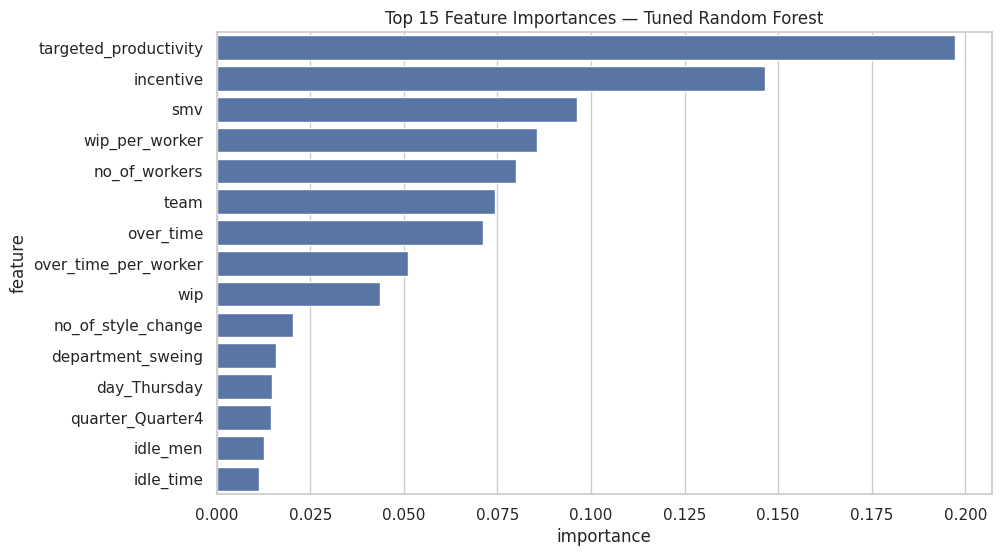

In [10]:
# Cell 9 — Feature importance

importances = rf_random.best_estimator_.named_steps['model'].feature_importances_
feature_names = rf_random.best_estimator_.named_steps['pre'].transformers_[0][2] + \
                list(rf_random.best_estimator_.named_steps['pre'].transformers_[1][1].get_feature_names_out())

feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp = feat_imp.sort_values(by='importance', ascending=False)

print("✅ Top 10 important features:")
display(feat_imp.head(10))

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feat_imp.head(15))
plt.title("Top 15 Feature Importances — Tuned Random Forest")
plt.show()


In [11]:
# — Save the model
import joblib

# Save the tuned Random Forest pipeline
joblib.dump(rf_random.best_estimator_, 'tuned_rf_productivity_model.pkl')
print("✅ Tuned Random Forest model saved as 'tuned_rf_productivity_model.pkl'")


✅ Tuned Random Forest model saved as 'tuned_rf_productivity_model.pkl'


In [12]:
#— Load and test the saved model
import joblib

# Load model
model = joblib.load('tuned_rf_productivity_model.pkl')
print("✅ Model loaded successfully.")

# Predict on test set
y_pred = model.predict(X_test)

# Compare predictions with actual
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
display(comparison.head(10))  # first 10 rows

# Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest Set Metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")


✅ Model loaded successfully.


,Actual,Predicted
478,1.000230,0.930732
724,0.700588,0.692261
312,0.650243,0.632727
851,0.733278,0.808648
1275,0.759271,0.659334
115,0.800594,0.799392
816,0.653431,0.662771
722,0.750406,0.752129
1142,0.700422,0.653957
101,0.681061,0.704815



Test Set Metrics:
RMSE: 0.1177
MAE: 0.0769
R²: 0.4972


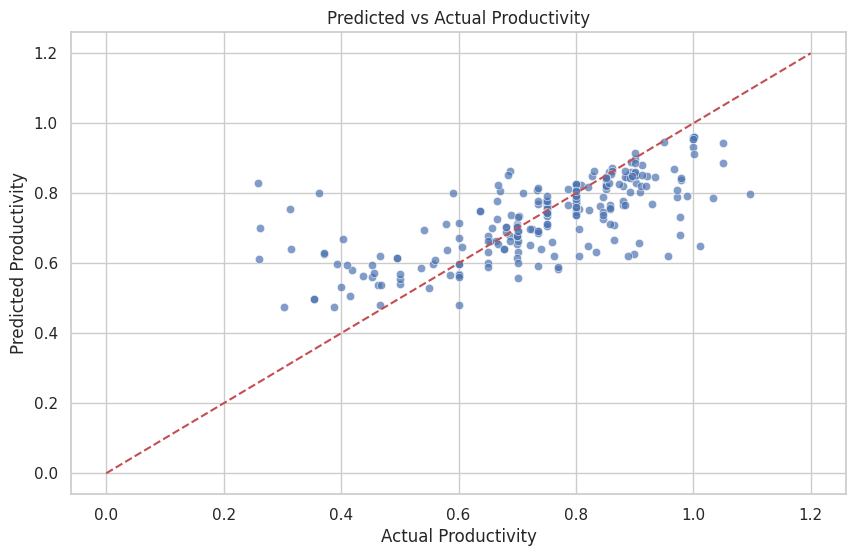

In [13]:
# Dashboard 1 — Predicted vs Actual
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([0, 1.2], [0, 1.2], 'r--')  # Perfect prediction line
plt.xlabel("Actual Productivity")
plt.ylabel("Predicted Productivity")
plt.title("Predicted vs Actual Productivity")
plt.show()


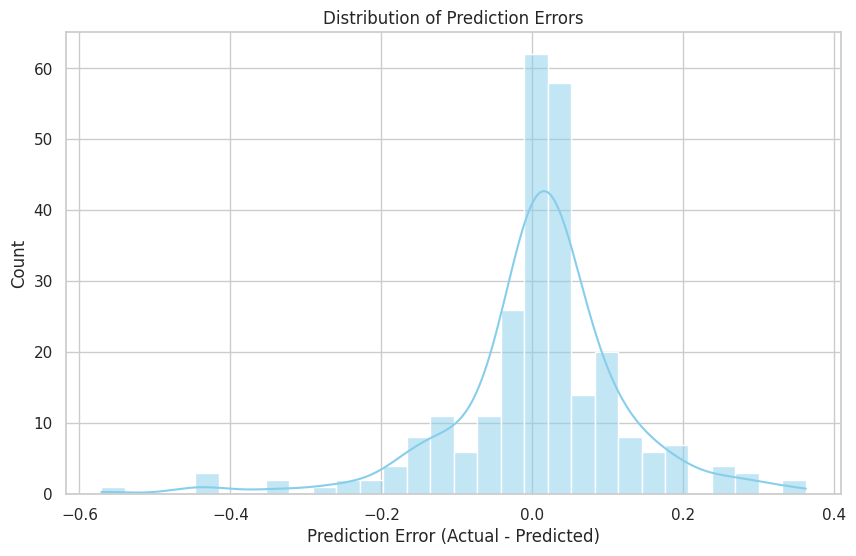

In [14]:
# Dashboard 2 — Error distribution
errors = y_test - y_pred
plt.figure(figsize=(10,6))
sns.histplot(errors, bins=30, kde=True, color='skyblue')
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.title("Distribution of Prediction Errors")
plt.show()


/tmp/ipython-input-1185919578.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feat_imp.head(15), palette='viridis')


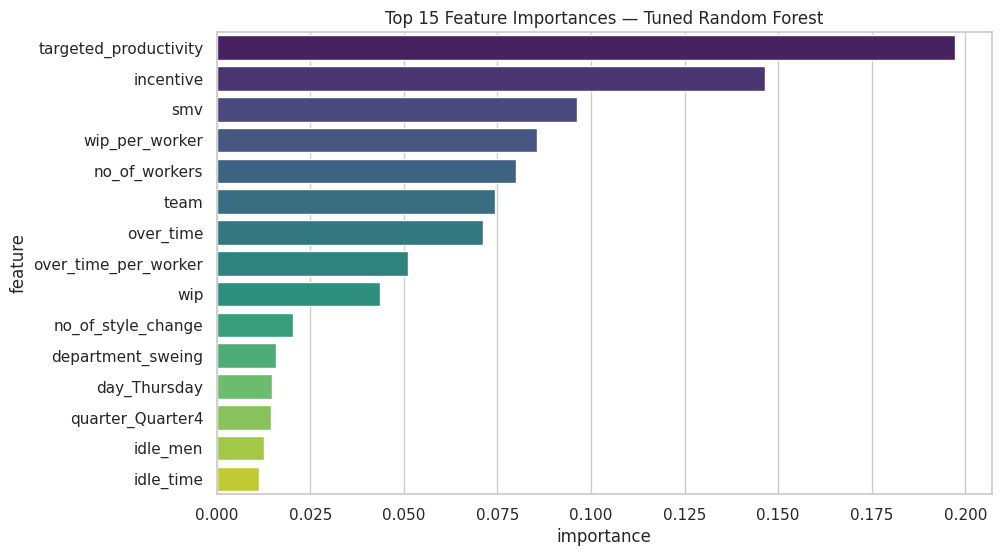

In [15]:
# Dashboard 3 — Feature Importance
plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feat_imp.head(15), palette='viridis')
plt.title("Top 15 Feature Importances — Tuned Random Forest")
plt.show()


In [16]:
# Ensure date column is datetime
df['date'] = pd.to_datetime(df['date'])

# Add predicted productivity column to the dataframe
df['predicted_productivity'] = model.predict(df[X_cols])

# Example: keep relevant columns for dashboards
df_dash = df[['date', 'department', 'team', 'actual_productivity', 'predicted_productivity']]


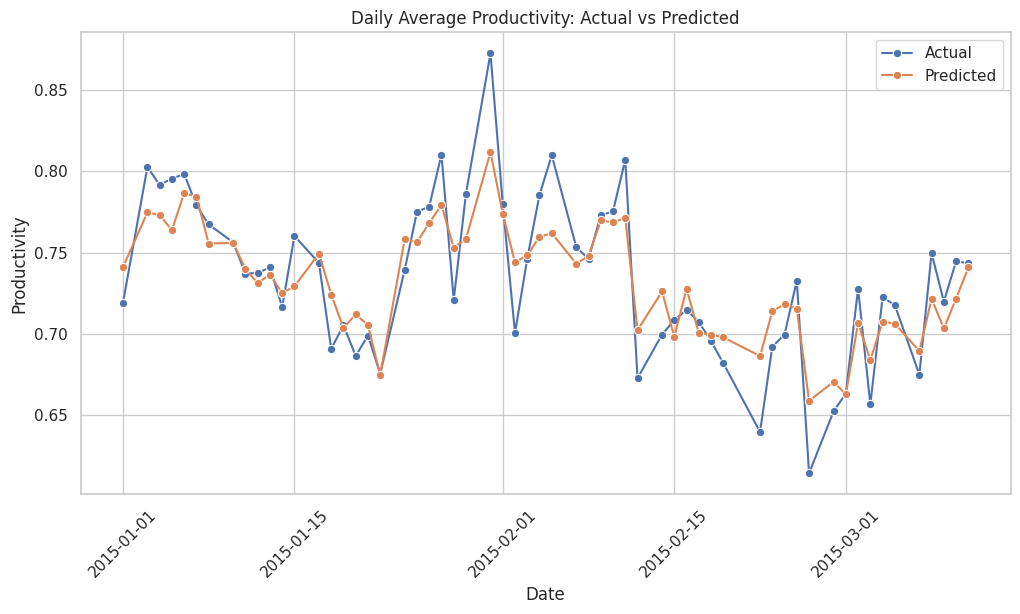

In [17]:
# Dashboard 4 — Time-series of actual vs predicted productivity
daily_prod = df_dash.groupby('date')[['actual_productivity','predicted_productivity']].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=daily_prod, x='date', y='actual_productivity', label='Actual', marker='o')
sns.lineplot(data=daily_prod, x='date', y='predicted_productivity', label='Predicted', marker='o')
plt.title("Daily Average Productivity: Actual vs Predicted")
plt.ylabel("Productivity")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.legend()
plt.show()


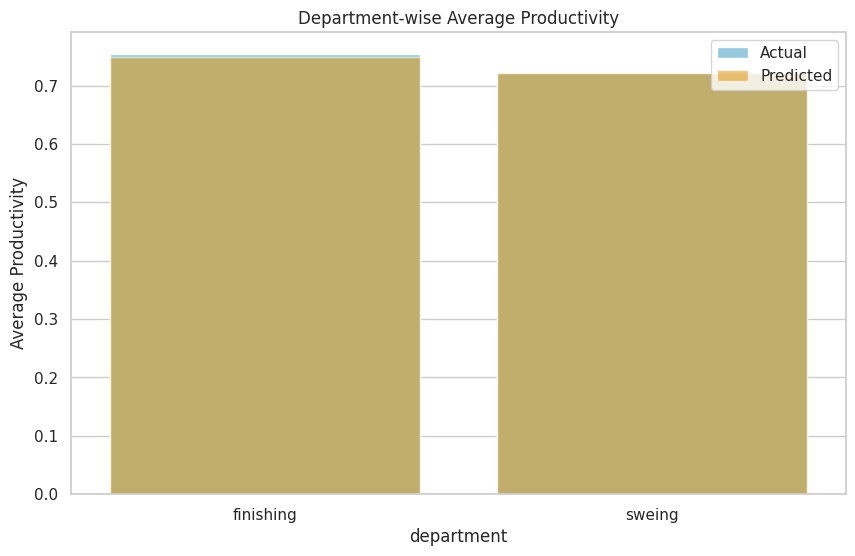

In [18]:
# Dashboard 5 — Department-wise comparison
dept_prod = df_dash.groupby('department')[['actual_productivity','predicted_productivity']].mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x='department', y='actual_productivity', data=dept_prod, color='skyblue', label='Actual')
sns.barplot(x='department', y='predicted_productivity', data=dept_prod, color='orange', alpha=0.6, label='Predicted')
plt.title("Department-wise Average Productivity")
plt.ylabel("Average Productivity")
plt.legend()
plt.show()


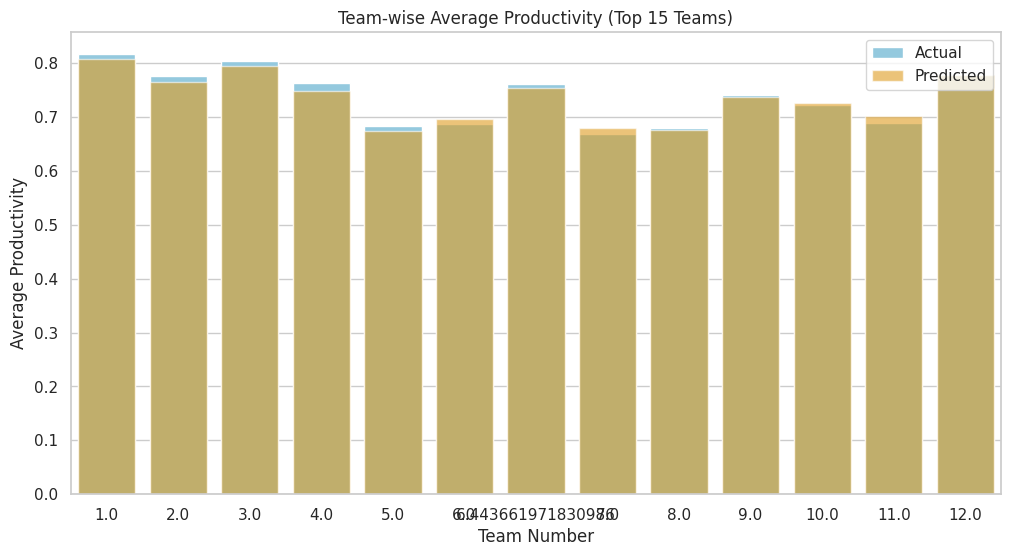

In [19]:
# Dashboard 6 — Team-wise comparison (top 15 teams by number of entries)
top_teams = df_dash['team'].value_counts().head(15).index
team_prod = df_dash[df_dash['team'].isin(top_teams)]
team_avg = team_prod.groupby('team')[['actual_productivity','predicted_productivity']].mean().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x='team', y='actual_productivity', data=team_avg, color='skyblue', label='Actual')
sns.barplot(x='team', y='predicted_productivity', data=team_avg, color='orange', alpha=0.6, label='Predicted')
plt.title("Team-wise Average Productivity (Top 15 Teams)")
plt.ylabel("Average Productivity")
plt.xlabel("Team Number")
plt.legend()
plt.show()


In [20]:
!pip install ipywidgets --quiet
from ipywidgets import interact, widgets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.9 MB/s eta 0:00:00


In [21]:
# Function to plot department productivity
def plot_department(dep):
    dept_data = df[df['department'] == dep].groupby('date')[['actual_productivity','predicted_productivity']].mean().reset_index()
    plt.figure(figsize=(12,6))
    sns.lineplot(data=dept_data, x='date', y='actual_productivity', label='Actual', marker='o')
    sns.lineplot(data=dept_data, x='date', y='predicted_productivity', label='Predicted', marker='o')
    plt.title(f"Productivity Trend — Department: {dep}")
    plt.ylabel("Productivity")
    plt.xlabel("Date")
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

# Dropdown widget for departments
departments = df['department'].unique()
interact(plot_department, dep=widgets.Dropdown(options=departments, description='Department:'));


interactive(children=(Dropdown(description='Department:', options=('sweing', 'finishing'), value='sweing'), Ou…

In [22]:
# Function to plot team productivity
def plot_team(team_num):
    team_data = df[df['team'] == team_num].groupby('date')[['actual_productivity','predicted_productivity']].mean().reset_index()
    plt.figure(figsize=(12,6))
    sns.lineplot(data=team_data, x='date', y='actual_productivity', label='Actual', marker='o')
    sns.lineplot(data=team_data, x='date', y='predicted_productivity', label='Predicted', marker='o')
    plt.title(f"Productivity Trend — Team: {team_num}")
    plt.ylabel("Productivity")
    plt.xlabel("Date")
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

# Dropdown widget for teams (top 20 teams by number of entries)
top_teams = df['team'].value_counts().head(20).index
interact(plot_team, team_num=widgets.Dropdown(options=top_teams, description='Team:'));


interactive(children=(Dropdown(description='Team:', options=(2.0, 8.0, 1.0, 4.0, 9.0, 12.0, 7.0, 5.0, 10.0, 11…